In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from scipy.special import expit, logit
import scipy.stats
from manipulation_matrices import *

In [3]:
#    R|RxR  L|RxR  R|RxL  L|RxL  R|LxL  L|LxL

D = [
    [841,  115,   113,   54,    1,    7],   # Ramaley 1913, paper says it does not fit
    [6917, 308,   411,   53,    18,    7],  # Chamberlain 1928
    [1842, 151,   140,   34,    5,     6],  # Rife 1940
    [140,  34,    33,    20,    8,     2],  # Merrell 1975
    [6206, 669,   471,   125,   5,     1],  # Annett 1973
    [154,  11,    31,    9,     0,     0],  # Ferronato et al. 1947
    [232,  17,    41,    7,     3,     1],  # Mascie-Taylor (unpub, in McManus 1985)
    [1060, 144,   122,   46,    3,     4],  # Chaurasia & Groswani (unpub, in McManus 1985)
    [1656, 130,   170,   40,    4,     0],  # Annett 1978
    [303,  37,    45,    15,    0,     0],  # Carter-Saltzmann 1980
    [315,  68,    57,    16,    0,     0],  # Coren & Porac 1980
    [848,  211,   325,   150,   30,   22],  # McGee & Cozad 1980
    [58,   9,     14,    5,     0,     0],  # McManus 1985 ICM1
    [134,  15,    17,    9,     1,     0],  # McManus 1985 ICM2prop
    [74,   4,     6,     2,     0,     0],  # McManus 1985 ICM2mat
    [86,   4,     8,     1,     0,     0],  # McManus 1985 ICM2pat
    [1729, 173,   281,   63,    8,     3]   # Leiber & Axelrod 1981
]
D = np.array(D)

# Descriptive

In [4]:
DD = D.sum(axis=0)
FR = (DD[0]*3 + DD[1]*2 + DD[2]*2 + DD[3] + DD[4]) / (DD.sum()*3)
print("Frequency of right-handed:", FR,'\n',"Frequency of left-handed:", 1-FR)

Frequency of right-handed: 0.9278065879189474 
 Frequency of left-handed: 0.07219341208105257


In [5]:
mp_total = []
mo_total = []

for D_ in D:
    mp, mo = compute_mp_mo(D_)
    mp_total.append(mp)
    mo_total.append(mo)

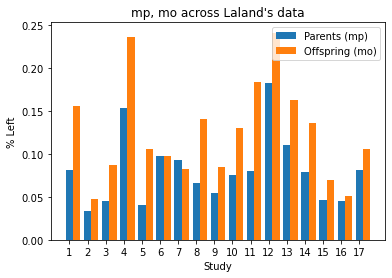

In [6]:

data1 = mp_total
data2 = mo_total

# labels = ['Ramaley 1913','Chamberlain 1928','Rife 1940','Merrell 1975', 'Annett 1973', 'Ferronato et al. 1947', 
            # 'Mascie-Taylor (unpub, in McManus 1985)', 'Chaurasia & Groswani', 'Annett 1978', 'Carter-Saltzmann 1980', 'Coren & Porac 1980',
            # 'McGee & Cozad 1980', 'McManus 1985 ICM1', 'McManus 1985 ICM2prop', 'McManus 1985 ICM2mat', 'McManus 1985 ICM2pat',
            # 'Leiber & Axelrod 1981']

labels = range(1,len(data1)+1)
plt.xticks(range(len(data1)), labels)

plt.xlabel('Study')
plt.ylabel('% Left')
plt.title("mp, mo across Laland's data")

width =0.4
plt.bar(np.arange(len(data1)), data1, width=width, label='Parents (mp)')
plt.bar(np.arange(len(data2))+ width, data2, width=width, label='Offspring (mo)')
plt.legend(loc="upper right")

plt.show()

# Grid MLE for θ

In [7]:
from concurrent.futures import ThreadPoolExecutor

In [8]:
pts = 100
ρs = np.linspace(0, 1, pts)
αs = np.linspace(0, 1, pts)
βs = np.linspace(0, 1, pts)
θs = np.array([ρs, αs, βs])
grid = np.meshgrid(ρs, αs, βs)

In [9]:
grid_logL = np.zeros((pts, pts, pts))
futs = grid_logL.tolist()

In [10]:
with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs[i][j][k] = pool.submit(log_likelihood, θ_, D)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [11]:
for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs[i][j][k].exception():
                print("Problem with", ρ_, α_, β_, ":", futs[i][j][k].exception())
                grid_logL[i, j, k] = -np.inf
            else:
                grid_logL[i, j, k] = futs[i][j][k].result()


In [12]:
imax = grid_logL.ravel().argmax()
θ_grid = (grid[0].ravel()[imax], grid[1].ravel()[imax], grid[2].ravel()[imax])

In [13]:
print("Grid MLE estimate, logL={:.5f}".format(log_likelihood(θ_grid, D)))
print("ρ={:.3f}, α={:.3f}, β={:.3f}".format(*θ_grid))

Grid MLE estimate, logL=-8566.42379
ρ=0.202, α=0.212, β=0.030


In [14]:
print("Predicted FDR:", 1 - compute_t(*θ_grid))
print("Observed FR:", FR)

Predicted FDR: 0.863299652214149
Observed FR: 0.9278065879189474


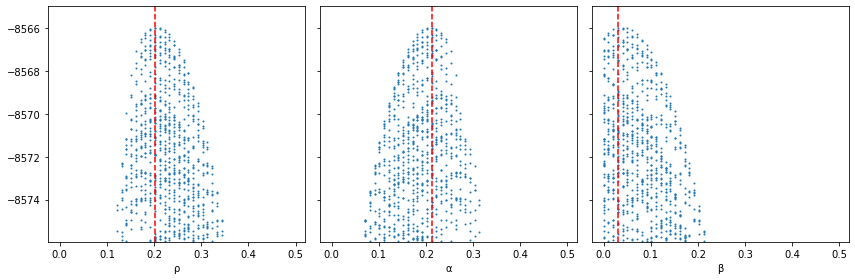

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), grid_logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylim(grid_logL.max() -10, grid_logL.max()+1)

fig.tight_layout()

Text(-0.5, 0.55, 'Laland 95')

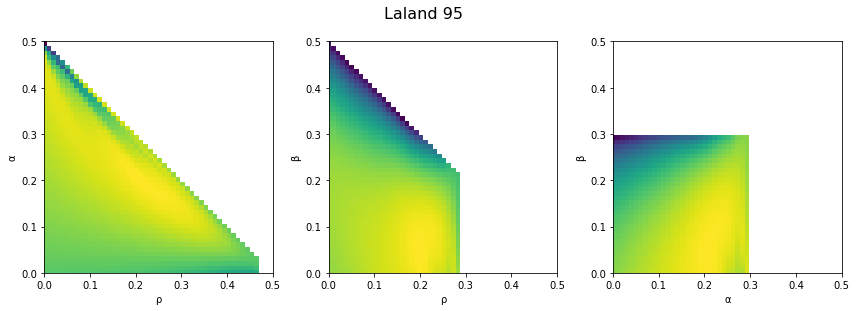

In [16]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.pcolormesh(ρs, αs, grid_logL[:, :, βs == θ_grid[2]].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[1]
ax.pcolormesh(ρs, βs, grid_logL[:, αs == θ_grid[1], :].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='β', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[2]
ax.pcolormesh(αs, βs, grid_logL[ρs == θ_grid[0], :, :].squeeze().T, cmap='viridis')
ax.set(ylabel='β', xlabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

fig.tight_layout()

plt.text(-0.5, 0.55, s='Laland 95', fontsize=16)


# Grids for P(u,v) and O(x,w)

## Grid for P -> mp (u,v)

In [17]:
def P_vars(θ, D):

    D = np.atleast_2d(D)
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if not validate(θ):
        return -np.inf


    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0 <= T) & (T <= 1)).all()
    assert 0 <= t <= 1
    
    
    for D_ in D:
        mp, mo = compute_mp_mo(D_)
        assert 0 < mp < 1
        assert 0 < mo < 1


    if mp > t:
        u = (mp - t) / mp
        v = np.NaN
        assert 0 <= u < 1

    else:
        v = (t - mp) / (1 - mp)  # fixed from: (t - mp)/t
        u = np.NaN

    if np.isnan(u):
        return v
    else:
        return u

In [19]:
grid_P = np.zeros((pts, pts, pts))
futs_P = grid_P.tolist()

with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs_P[i][j][k] = pool.submit(P_vars, θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs_P[i][j][k].exception():
                print("Problem with", ρ_, α_, β_, ":", futs_P[i][j][k].exception())
                grid_P[i, j, k] = -np.inf
            else:
                grid_P[i, j, k] = futs_P[i][j][k].result()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

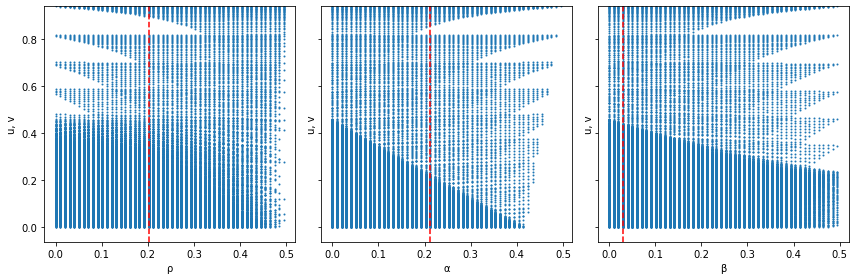

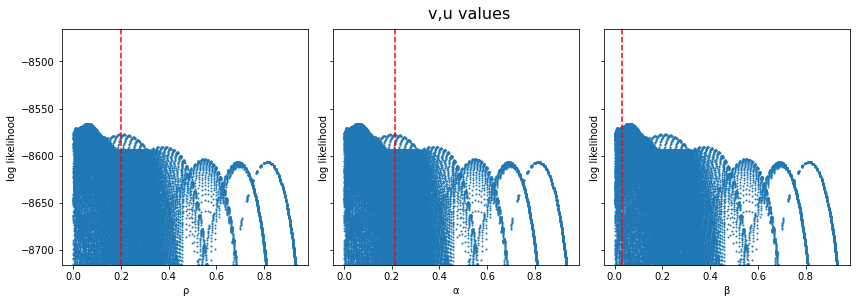

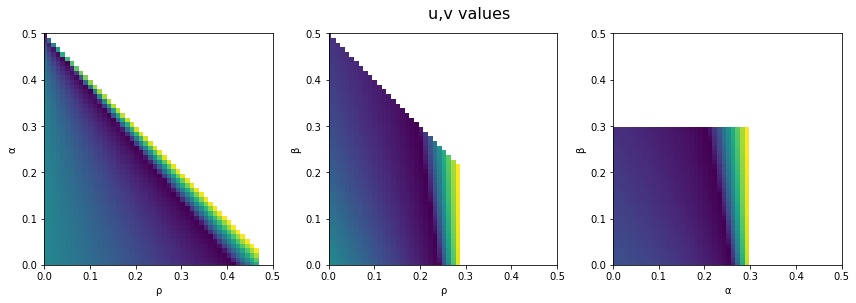

In [20]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), grid_P.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel("u, v")
    ax.set_ylim(grid_P.max() -1, grid_P.max())

fig.tight_layout()


fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid_P.ravel(), grid_logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('log likelihood')
    ax.set_ylim(grid_logL.max()-150, grid_logL.max()+100)

fig.text(0.5, 1, s='v,u values', fontsize =16)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.pcolormesh(ρs, αs, grid_P[:, :, βs == θ_grid[2]].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[1]
ax.pcolormesh(ρs, βs, grid_P[:, αs == θ_grid[1], :].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='β', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[2]
ax.pcolormesh(αs, βs, grid_P[ρs == θ_grid[0], :, :].squeeze().T, cmap='viridis')
ax.set(ylabel='β', xlabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

fig.text(0.5, 1, s='u,v values', fontsize =16)

fig.tight_layout()

### grid for U

In [21]:
def P_vars_u(θ, D):

    D = np.atleast_2d(D)
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if not validate(θ):
        return -np.inf


    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0 <= T) & (T <= 1)).all()
    assert 0 <= t <= 1
    
    
    for D_ in D:
        mp, mo = compute_mp_mo(D_)
        assert 0 < mp < 1
        assert 0 < mo < 1


    if mp > t:
        u = (mp - t) / mp
        v = np.NaN
        assert 0 <= u < 1

    else:
        v = (t - mp) / (1 - mp)  # fixed from: (t - mp)/t
        u = np.NaN

    # if np.isnan(u):
    #     return v
    # else:
    return u

In [22]:
grid_Pu = np.zeros((pts, pts, pts))
futs_Pu = grid_Pu.tolist()

with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs_Pu[i][j][k] = pool.submit(P_vars_u, θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs_Pu[i][j][k].exception():
                print("Problem with", ρ_, α_, β_, ":", futs_Pu[i][j][k].exception())
                grid_Pu[i, j, k] = -np.inf
            else:
                grid_Pu[i, j, k] = futs_Pu[i][j][k].result()
##


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

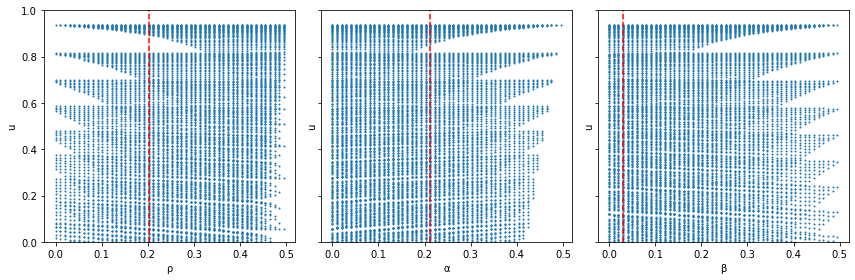

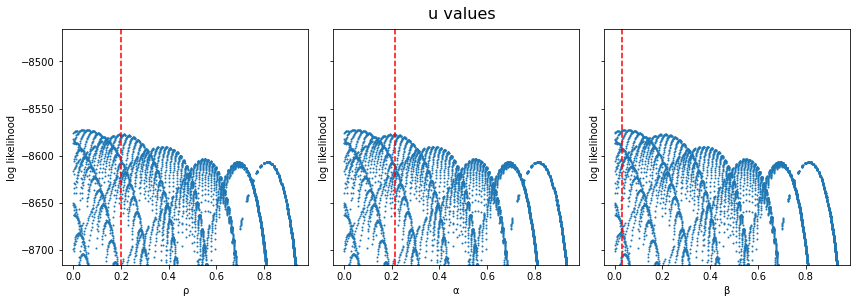

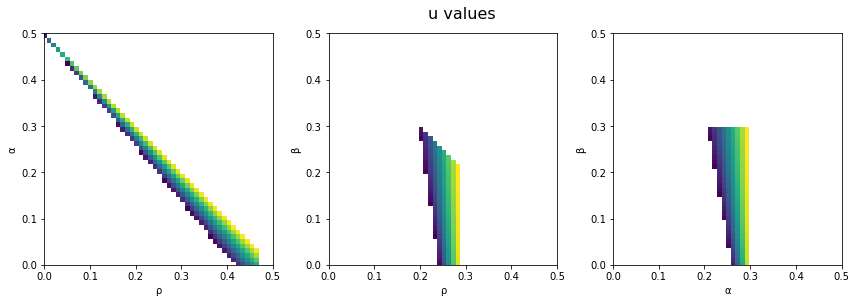

In [23]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), grid_Pu.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel("u")
    ax.set_ylim(0, 1)

fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid_Pu.ravel(), grid_logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('log likelihood')
    ax.set_ylim(grid_logL.max()-150, grid_logL.max()+100)

fig.text(0.5, 1, s='u values', fontsize =16)
fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.pcolormesh(ρs, αs, grid_Pu[:, :, βs == θ_grid[2]].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[1]
ax.pcolormesh(ρs, βs, grid_Pu[:, αs == θ_grid[1], :].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='β', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[2]
ax.pcolormesh(αs, βs, grid_Pu[ρs == θ_grid[0], :, :].squeeze().T, cmap='viridis')
ax.set(ylabel='β', xlabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

fig.text(0.5, 1, s='u values', fontsize =16)

fig.tight_layout()

### Grid for v

In [24]:
def P_vars_v(θ, D):

    D = np.atleast_2d(D)
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if not validate(θ):
        return -np.inf


    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0 <= T) & (T <= 1)).all()
    assert 0 <= t <= 1
    
    
    for D_ in D:
        mp, mo = compute_mp_mo(D_)
        assert 0 < mp < 1
        assert 0 < mo < 1


    if mp > t:
        u = (mp - t) / mp
        v = np.NaN
        assert 0 <= u < 1

    else:
        v = (t - mp) / (1 - mp)  # fixed from: (t - mp)/t
        u = np.NaN

    # if np.isnan(u):
    return v
    # else:
    # return u

In [25]:
grid_Pv = np.zeros((pts, pts, pts))
futs_Pv = grid_Pv.tolist()

with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs_Pv[i][j][k] = pool.submit(P_vars_v, θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs_Pv[i][j][k].exception():
                print("Problem with", ρ_, α_, β_, ":", futs_Pv[i][j][k].exception())
                grid_Pv[i, j, k] = -np.inf
            else:
                grid_Pv[i, j, k] = futs_Pv[i][j][k].result()



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

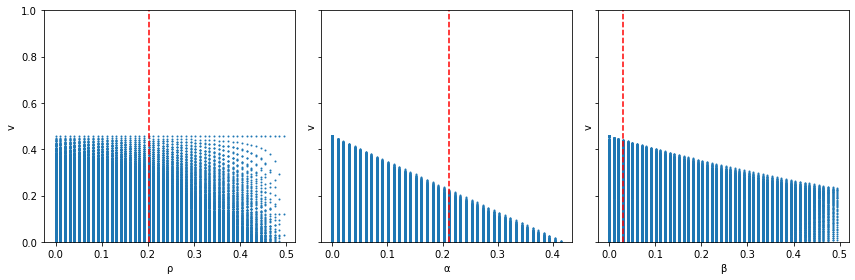

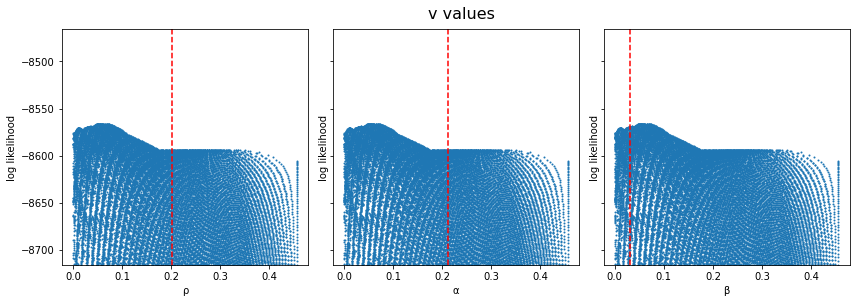

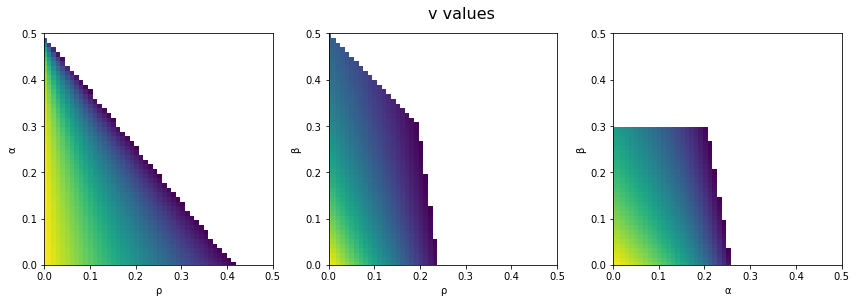

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), grid_Pv.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel("v")
    ax.set_ylim(0, 1)

fig.tight_layout()

##


fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid_Pv.ravel(), grid_logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('log likelihood')
    ax.set_ylim(grid_logL.max()-150, grid_logL.max()+100)

fig.text(0.5, 1, s='v values', fontsize =16)
fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.pcolormesh(ρs, αs, grid_Pv[:, :, βs == θ_grid[2]].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[1]
ax.pcolormesh(ρs, βs, grid_Pv[:, αs == θ_grid[1], :].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='β', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[2]
ax.pcolormesh(αs, βs, grid_Pv[ρs == θ_grid[0], :, :].squeeze().T, cmap='viridis')
ax.set(ylabel='β', xlabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

fig.text(0.5, 1, s='v values', fontsize =16)

fig.tight_layout()

## Grid for O -> (x,w)

In [27]:
def O_vars(θ, D):

    D = np.atleast_2d(D)
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if not validate(θ):
        return -np.inf


    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0 <= T) & (T <= 1)).all()
    assert 0 <= t <= 1
    
    
    for D_ in D:
        mp, mo = compute_mp_mo(D_)
        assert 0 < mp < 1
        assert 0 < mo < 1


    if mo > t:
        w = (mo - t) / (1 - t)
        x = np.NaN
        assert 0 <= w < 1
    else:
        x = 1 - mo / t
        w = np.NaN
        assert 0 <= x <= 1

    if np.isnan(w):
        return x
    else:
        return w

In [28]:
grid_O = np.zeros((pts, pts, pts))
futs_O = grid_O.tolist()

with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs_O[i][j][k] = pool.submit(O_vars, θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs_O[i][j][k].exception():
                print("Problem with", ρ_, α_, β_, ":", futs_O[i][j][k].exception())
                grid_O[i, j, k] = -np.inf
            else:
                grid_O[i, j, k] = futs_O[i][j][k].result()





0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

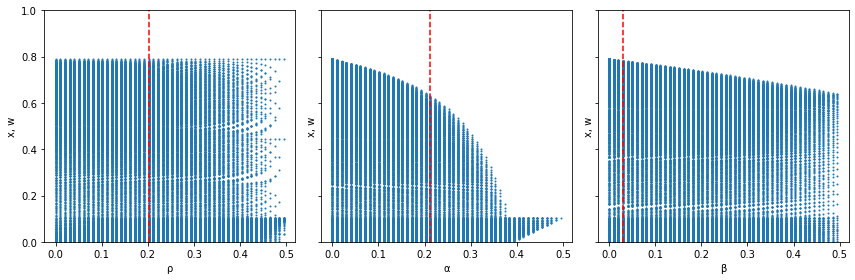

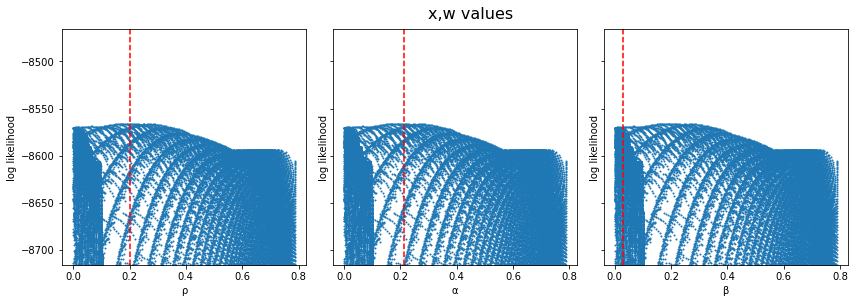

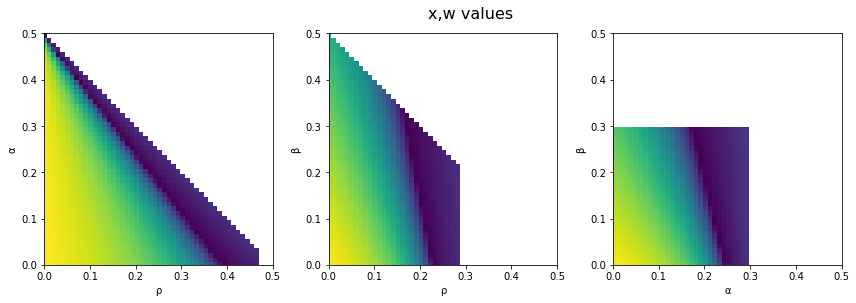

In [29]:

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), grid_O.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel("x, w")
    ax.set_ylim(0,1)

fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid_O.ravel(), grid_logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('log likelihood')
    ax.set_ylim(grid_logL.max()-150, grid_logL.max()+100)

fig.text(0.5, 1, s='x,w values', fontsize =16)
fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.pcolormesh(ρs, αs, grid_O[:, :, βs == θ_grid[2]].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[1]
ax.pcolormesh(ρs, βs, grid_O[:, αs == θ_grid[1], :].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='β', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[2]
ax.pcolormesh(αs, βs, grid_O[ρs == θ_grid[0], :, :].squeeze().T, cmap='viridis')
ax.set(ylabel='β', xlabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

fig.text(0.5, 1, s='x,w values', fontsize =16)

fig.tight_layout()


### Grid for x

In [30]:
def O_vars_x(θ, D):

    D = np.atleast_2d(D)
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if not validate(θ):
        return -np.inf


    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0 <= T) & (T <= 1)).all()
    assert 0 <= t <= 1
    
    
    for D_ in D:
        mp, mo = compute_mp_mo(D_)
        assert 0 < mp < 1
        assert 0 < mo < 1


    if mo > t:
        w = (mo - t) / (1 - t)
        x = np.NaN
        assert 0 <= w < 1
    else:
        x = 1 - mo / t
        w = np.NaN
        assert 0 <= x <= 1

    # if np.isnan(w):
    #     return x
    # else:
    #     return w
    return x

In [31]:
grid_Ox = np.zeros((pts, pts, pts))
futs_Ox = grid_Ox.tolist()

with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs_Ox[i][j][k] = pool.submit(O_vars_x, θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs_Ox[i][j][k].exception():
                print("Problem with", ρ_, α_, β_, ":", futs_Ox[i][j][k].exception())
                grid_Ox[i, j, k] = -np.inf
            else:
                grid_Ox[i, j, k] = futs_Ox[i][j][k].result()


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

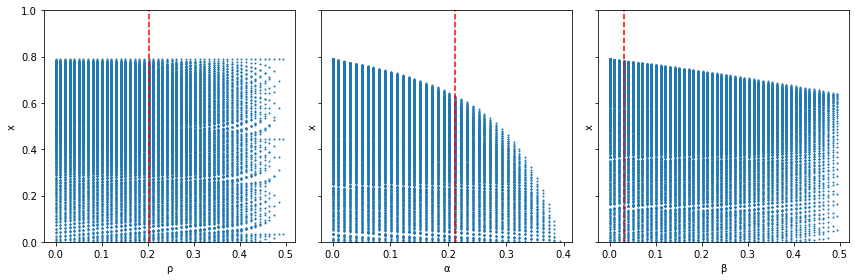

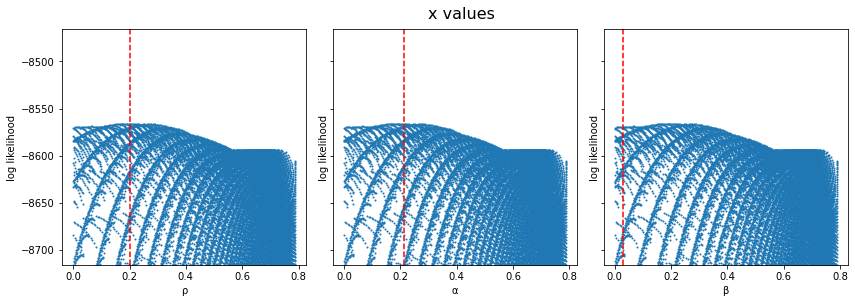

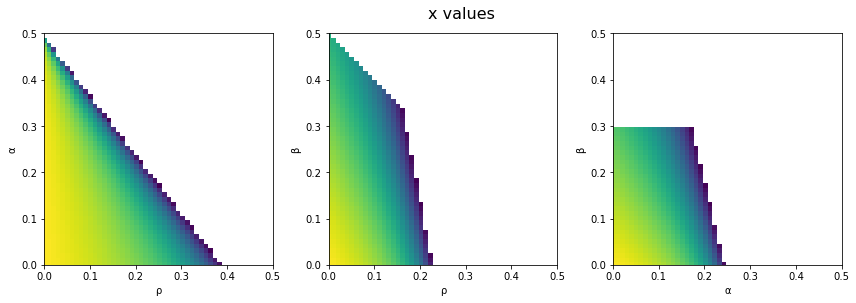

In [32]:


# Plots

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), grid_Ox.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel("x")
    ax.set_ylim(0,1)

fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid_Ox.ravel(), grid_logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('log likelihood')
    ax.set_ylim(grid_logL.max()-150, grid_logL.max()+100)

fig.text(0.5, 1, s='x values', fontsize =16)
fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.pcolormesh(ρs, αs, grid_Ox[:, :, βs == θ_grid[2]].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[1]
ax.pcolormesh(ρs, βs, grid_Ox[:, αs == θ_grid[1], :].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='β', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[2]
ax.pcolormesh(αs, βs, grid_Ox[ρs == θ_grid[0], :, :].squeeze().T, cmap='viridis')
ax.set(ylabel='β', xlabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

fig.text(0.5, 1, s='x values', fontsize =16)

fig.tight_layout()


### Grid for w

In [33]:
def O_vars_w(θ, D):

    D = np.atleast_2d(D)
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    if not validate(θ):
        return -np.inf


    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)
    assert ((0 <= T) & (T <= 1)).all()
    assert 0 <= t <= 1
    
    
    for D_ in D:
        mp, mo = compute_mp_mo(D_)
        assert 0 < mp < 1
        assert 0 < mo < 1


    if mo > t:
        w = (mo - t) / (1 - t)
        x = np.NaN
        assert 0 <= w < 1
    else:
        x = 1 - mo / t
        w = np.NaN
        assert 0 <= x <= 1

    # if np.isnan(w):
    #     return x
    # else:
    return w

In [34]:
grid_Ow = np.zeros((pts, pts, pts))
futs_Ow = grid_Ow.tolist()

with ThreadPoolExecutor() as pool:
    for i, ρ_ in enumerate(ρs):
        print(i, end=' ', flush=True)
        for j, α_ in enumerate(αs):
            for k, β_ in enumerate(βs):
                θ_ = ρ_, α_, β_
                futs_Ow[i][j][k] = pool.submit(O_vars_w, θ_, D)

for i, ρ_ in enumerate(ρs):
    for j, α_ in enumerate(αs):
        for k, β_ in enumerate(βs):
            if futs_Ow[i][j][k].exception():
                print("Problem with", ρ_, α_, β_, ":", futs_Ow[i][j][k].exception())
                grid_Ow[i, j, k] = -np.inf
            else:
                grid_Ow[i, j, k] = futs_Ow[i][j][k].result()



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

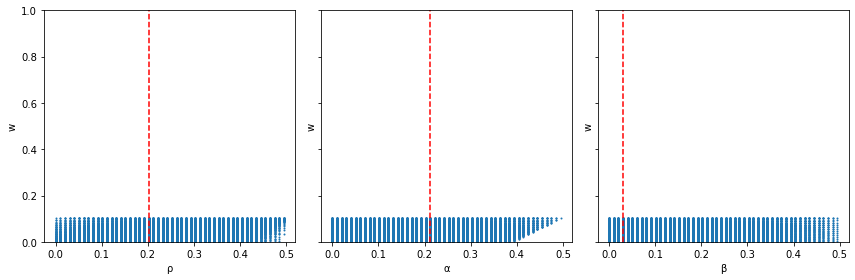

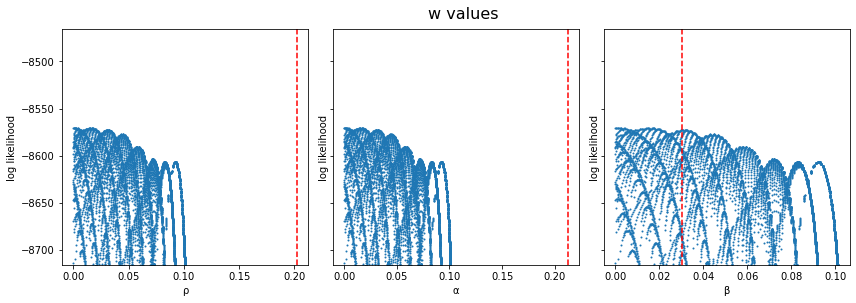

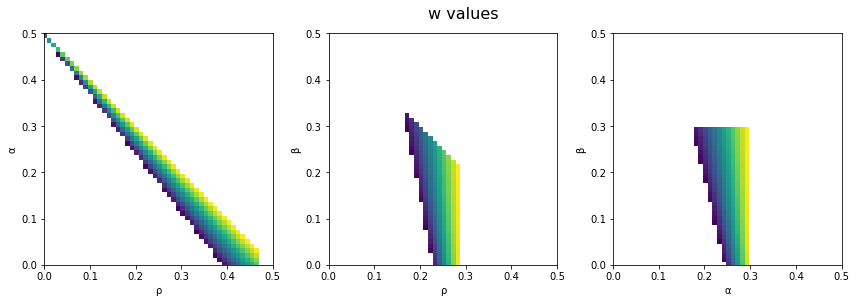

In [35]:

# Plots

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid[i].ravel(), grid_Ow.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel("w")
    ax.set_ylim(0,1)

fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
labels = 'ρ α β'.split()
for i in range(3):
    ax = axes[i]
    ax.plot(grid_Ow.ravel(), grid_logL.ravel(), '.', markersize=2)
    ax.axvline(θ_grid[i], ls='--', color='r')
    # ax.axhline(log_likelihood(θ_grid, D))
    # ax.axvline(θ_mle[i], color='g')
    # ax.axvline(θ_1995[i], color='k')
    # ax.set_xscale('log')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('log likelihood')
    ax.set_ylim(grid_logL.max()-150, grid_logL.max()+100)

fig.text(0.5, 1, s='w values', fontsize =16)
fig.tight_layout()

##
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.pcolormesh(ρs, αs, grid_Ow[:, :, βs == θ_grid[2]].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[1]
ax.pcolormesh(ρs, βs, grid_Ow[:, αs == θ_grid[1], :].squeeze().T, cmap='viridis')
ax.set(xlabel='ρ', ylabel='β', xlim=(0, 0.5), ylim=(0, 0.5))

ax = axes[2]
ax.pcolormesh(αs, βs, grid_Ow[ρs == θ_grid[0], :, :].squeeze().T, cmap='viridis')
ax.set(ylabel='β', xlabel='α', xlim=(0, 0.5), ylim=(0, 0.5))

fig.text(0.5, 1, s='w values', fontsize =16)

fig.tight_layout()
